# Анализ трендовых видео на YouTube (ссылка на набор данных: https://www.kaggle.com/datasets/datasnaek/youtube-new).


In [104]:
import pandas as pd  
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import warnings

df = pd.read_csv('./Pet-project YouTube/USvideos1.csv', sep = ';', encoding="latin-1", low_memory=False)


df.drop(df.iloc[:, 16:29], inplace=True, axis=1)
df.dropna(thresh=5, inplace=True)
df = df.loc[~df["video_id"].str.contains(r"\\n|#ÈÌß?|Cook with confidence using Bon Appetitâs kitchen tips")]
df = df.loc[~df['trending_date'].str.contains(r'[a-z]')]
df['publish_time'] = pd.to_datetime(df['publish_time']).dt.tz_convert(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], dayfirst=True)

df[['views', 'likes', 'dislikes', 'comment_count']] = df[['views', 'likes', 'dislikes', 'comment_count']].astype("Int64")   
df = df.replace({'category_id':{ '1':'Film & Animation', '2':'Autos & Vehicles','10':'Music','15':'Pets & Animals',\
                                '17':'Sports','18':'Short Movies','19':'Travel & Events','20':'Gaming',\
                                '21':'Videoblogging','22':'People & Blogs','23':'Comedy','24':'Entertainment',\
                                '25':'News & Politics','26':'Howto & Style','27':'Education','28':'Science & Technology',\
                                '29':'Nonprofits & Activism', '30':'Movies','31':'Anime/Animation','32':'Action/Adventure',\
                                '33':'Classics','34':'Comedy','35':'Documentary','36':'Drama','37':'Family','38':'Foreign',\
                                '39':'Horror','40':'Sci-Fi/Fantasy','41':'Thriller','42':'Shorts','43':'Shows','44':'Trailers',}}) 

df.rename(columns = {'category_id':'category'}, inplace = True )
df = df.fillna(0)


### Добавим новые столбцы: 'like_percent', 'dislike_percent', 'positive_or_negative', позволяющие определить % лайков и дизлайков у видео

In [93]:
like_percent = pd.DataFrame((df['likes'] / df['views']) * 100)
dislike_percent = pd.DataFrame((df['dislikes'] / df['views']) * 100)
df['like_percent'] = like_percent
df['dislike_percent'] = dislike_percent
df['positive_or_negative'] = df['like_percent'] > df['dislike_percent']

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40473 entries, 0 to 48696
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                40473 non-null  object        
 1   trending_date           40473 non-null  datetime64[ns]
 2   title                   40473 non-null  object        
 3   channel_title           40473 non-null  object        
 4   category                40473 non-null  object        
 5   publish_time            40473 non-null  datetime64[ns]
 6   tags                    40473 non-null  object        
 7   views                   40473 non-null  Int64         
 8   likes                   40473 non-null  Int64         
 9   dislikes                40473 non-null  Int64         
 10  comment_count           40473 non-null  Int64         
 11  thumbnail_link          40473 non-null  object        
 12  comments_disabled       40473 non-null  object     

In [95]:
df.head()

,video_id,trending_date,title,channel_title,category,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,like_percent,dislike_percent,positive_or_negative
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13 17:13:01,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,7.686932,0.396326,True
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",4.01793,0.254095,True
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO â¶ \n\nSUBSCRIBE âº ...,4.57578,0.167292,True
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,2.964146,0.194074,True
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,Entertainment,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,6.309732,0.094907,True


### Топ 3 самых популярных видео по просмотрам

In [96]:
df.groupby('video_id').agg({'views': 'max'}).sort_values('views', ascending =False).head(3)                       

,views
video_id,
VYOjWnS4cMY,225211923
FlsCjmMhFmw,149376127
ffxKSjUwKdU,148689896


### Топ 5 категорий по просмотрам

In [97]:
df.groupby('category').agg({'views': 'sum'}).sort_values('views', ascending =False).head() 

,views
category,
Music,39289417231
Entertainment,20516669151
Film & Animation,7278769234
Comedy,4945411894
People & Blogs,4870926687


### Конверсия лайков к количеству просмотров по категориям, в процентах

In [98]:
conversion_likes_by_views = df.groupby(['category']).apply(lambda x: x['likes'].sum() / x['views'].sum()*100)
conversion_likes_by_views

category
Autos & Vehicles         0.815535
Comedy                   4.166521
Education                4.189331
Entertainment            2.574690
Film & Animation         2.278732
Gaming                   3.224210
Howto & Style            3.992782
Music                    3.575764
News & Politics          1.231359
Nonprofits & Activism    8.769696
People & Blogs           3.787377
Pets & Animals           2.526272
Science & Technology     2.331721
Shows                    2.102168
Sports                   2.235238
Travel & Events          1.407698
dtype: float64

### График конверсии лайков к количеству просмотров по категориям, в процентах

<Axes: title={'center': 'Conversion of likes by views'}, xlabel='conversion, %', ylabel='category'>

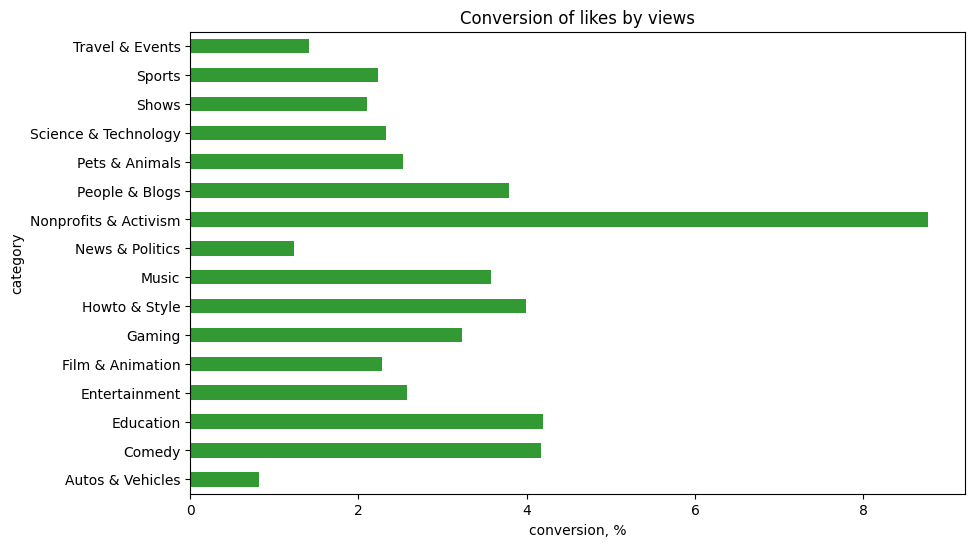

In [99]:
conversion_likes_by_views.plot.barh(color = 'g', alpha = 0.8, figsize = (10,6), xlabel='conversion, %', ylabel='category',\
                                   title='Conversion of likes by views')


### Построим график соотношения лайков и дизлайков по категориям видео 

In [100]:
video_feel = []
for item in df['positive_or_negative']:
    if item == True:
        video_feel.append(1)
    else:
        video_feel.append(0)
df['positive_or_negative'] = video_feel

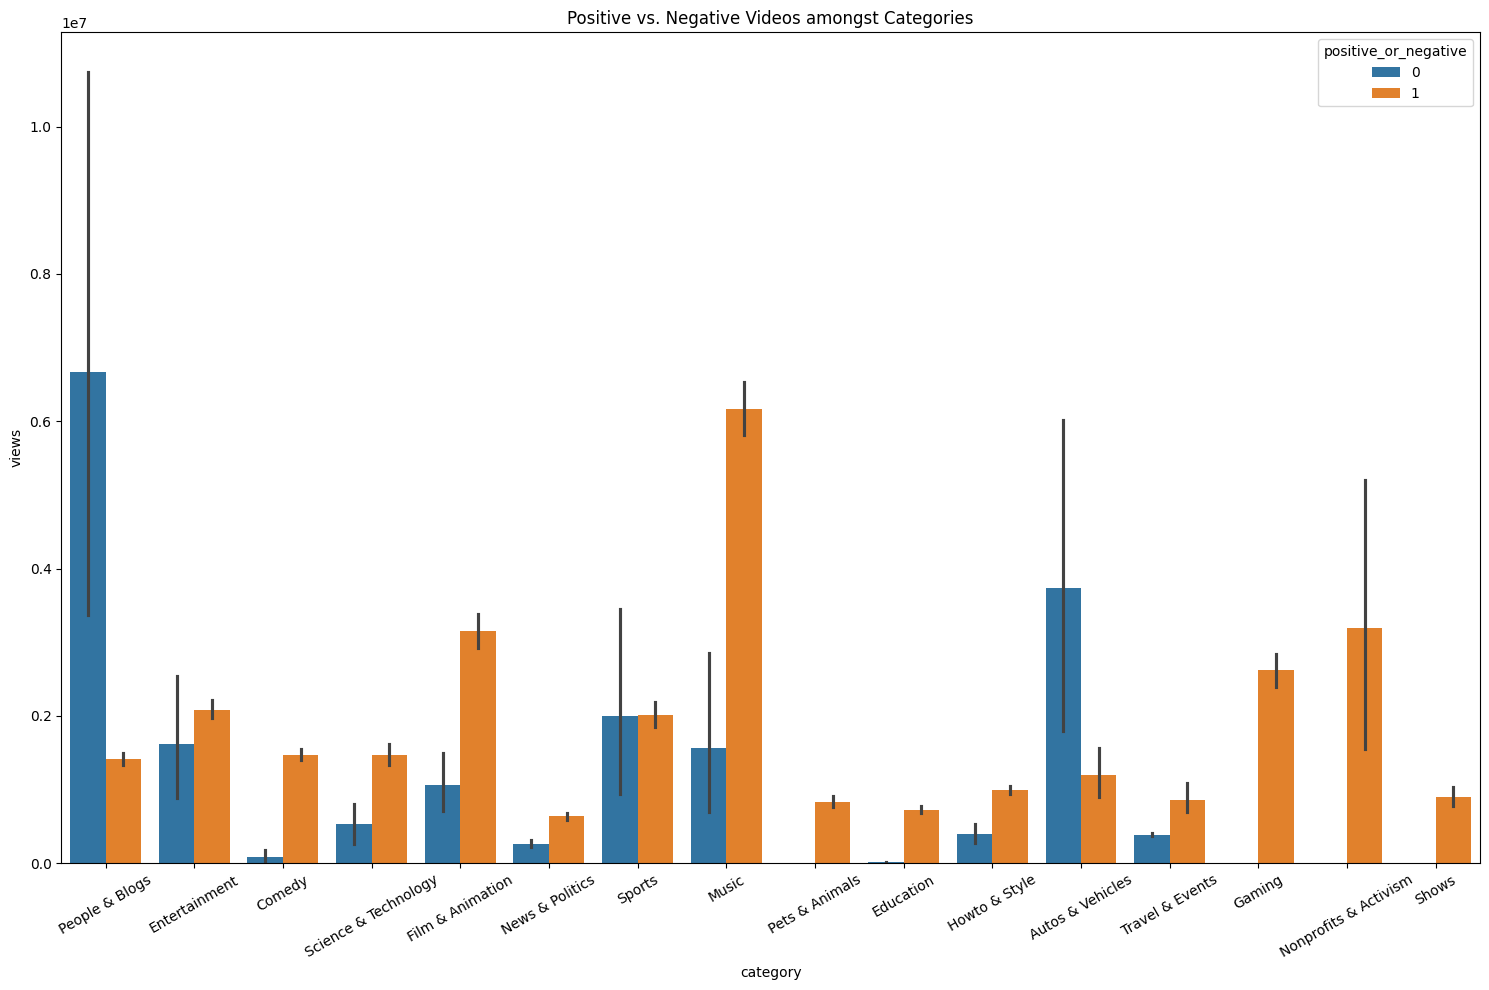

In [101]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,10))
g = sns.barplot(x=df['category'],y=df['views'],hue=df['positive_or_negative'],data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
plt.title('Positive vs. Negative Videos amongst Categories')
plt.tight_layout()

### На графике мы видим ярко выраженную разницу между количеством лайков и дизлайков в категориях "People & Blogs",  "Autos & Vehicles". Похоже, что видео в этих категориях, как правило, более негативные, чем позитивные. А категория "Music", наоборот, нравится людям больше.